In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
!pip install pytorchcv

     |████████████████████████████████| 368kB 2.8MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import fastai
from fastai.vision import *
from pytorchcv.model_provider import get_model as ptcv_get_model
import warnings
warnings.filterwarnings('ignore')

In [5]:
print(fastai.__version__)

1.0.59


In [6]:
path = Path("/content/drive/My Drive/dla-project/data/")
path.ls()

[PosixPath('/content/drive/My Drive/dla-project/data/test'),
 PosixPath('/content/drive/My Drive/dla-project/data/train')]

In [0]:
bs = 32 
size = 256
tfms = ([crop_pad()], [])

In [8]:
src = ImageList.from_folder(path/'train').split_by_rand_pct().label_from_folder().transform(tfms, size=size)   
src

LabelLists;

Train: LabelList (884 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
turbines_low_capacity,turbines_low_capacity,turbines_low_capacity,turbines_low_capacity,turbines_low_capacity
Path: /content/drive/My Drive/dla-project/data/train;

Valid: LabelList (220 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
turbines_low_capacity,turbines_high_capacity,turbines_high_capacity,turbines_low_capacity,no_turbines_med_potential
Path: /content/drive/My Drive/dla-project/data/train;

Test: None

In [0]:
#Creating Databunch (Loaders) and Normalizing
data = (src).databunch(bs=bs).normalize(imagenet_stats)

In [0]:
#Labels
data.classes

['no_turbines_high_potential',
 'no_turbines_low_potential',
 'no_turbines_med_potential',
 'no_turbines_no_potential',
 'turbines_high_capacity',
 'turbines_low_capacity',
 'turbines_medium_capacity']

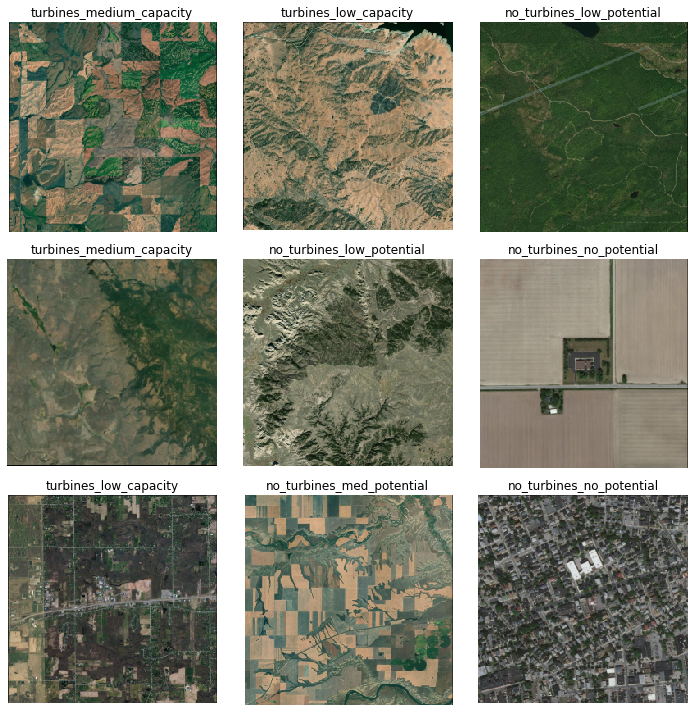

In [0]:
#Example Batch
data.show_batch(rows=3, figsize=(10, 10))

In [0]:
#https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/utils.py
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')


def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

In [0]:
#Elected Architecture
arch = ptcv_get_model("efficientnet_b1", pretrained=True)
arch_summary(lambda _: arch.features)

(0) EffiInitBlock: 3   layers (total: 3)
(1) Sequential  : 20  layers (total: 23)
(2) Sequential  : 39  layers (total: 62)
(3) Sequential  : 39  layers (total: 101)
(4) Sequential  : 104 layers (total: 205)
(5) Sequential  : 91  layers (total: 296)
(6) ConvBlock   : 3   layers (total: 299)
(7) AdaptiveAvgPool2d: 1   layers (total: 300)


In [0]:
for i in range(6):
    print(f'---------({i})---------')
    arch_summary(lambda _: arch.features[i])

---------(0)---------
(0) ConvBlock   : 3   layers (total: 3)
---------(1)---------
(0) EffiDwsConvUnit: 10  layers (total: 10)
(1) EffiDwsConvUnit: 10  layers (total: 20)
---------(2)---------
(0) EffiInvResUnit: 13  layers (total: 13)
(1) EffiInvResUnit: 13  layers (total: 26)
(2) EffiInvResUnit: 13  layers (total: 39)
---------(3)---------
(0) EffiInvResUnit: 13  layers (total: 13)
(1) EffiInvResUnit: 13  layers (total: 26)
(2) EffiInvResUnit: 13  layers (total: 39)
---------(4)---------
(0) EffiInvResUnit: 13  layers (total: 13)
(1) EffiInvResUnit: 13  layers (total: 26)
(2) EffiInvResUnit: 13  layers (total: 39)
(3) EffiInvResUnit: 13  layers (total: 52)
(4) EffiInvResUnit: 13  layers (total: 65)
(5) EffiInvResUnit: 13  layers (total: 78)
(6) EffiInvResUnit: 13  layers (total: 91)
(7) EffiInvResUnit: 13  layers (total: 104)
---------(5)---------
(0) EffiInvResUnit: 13  layers (total: 13)
(1) EffiInvResUnit: 13  layers (total: 26)
(2) EffiInvResUnit: 13  layers (total: 39)
(3) Effi

In [0]:
def efficientnet_b1(pretrained=True):
    return ptcv_get_model("efficientnet_b1", pretrained=pretrained).features

#Fastai Learner (Model with built-in Training Tools)
learn = cnn_learner(data, efficientnet_b1, pretrained=True, cut=noop, split_on=lambda m: (m[0][4], m[1]), metrics=[error_rate, accuracy])

In [0]:
get_groups(nn.Sequential(*learn.model[0], *learn.model[1]), learn.layer_groups)

Group 1: ['EffiInitBlock', 'Sequential', 'Sequential', 'Sequential']
Group 2: ['Sequential', 'Sequential', 'ConvBlock', 'AdaptiveAvgPool2d']
Group 3: ['AdaptiveConcatPool2d', 'Flatten', 'BatchNorm1d', 'Dropout', 'Linear', 'ReLU', 'BatchNorm1d', 'Dropout', 'Linear']


In [0]:
print(learn.loss_func)

FlattenedLoss of CrossEntropyLoss()


In [0]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 128, 128]       864        False     
______________________________________________________________________
BatchNorm2d          [32, 128, 128]       64         True      
______________________________________________________________________
Swish                [32, 128, 128]       0          False     
______________________________________________________________________
Conv2d               [32, 128, 128]       288        False     
______________________________________________________________________
BatchNorm2d          [32, 128, 128]       64         True      
______________________________________________________________________
Swish                [32, 128, 128]       0          False     
______________________________________________________________________
AdaptiveAvgPool2d    [32, 1, 1]           0          False     
___________________________________________________

In [0]:
gc.collect()

23

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


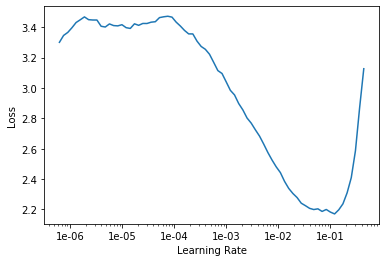

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
gc.collect()

0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


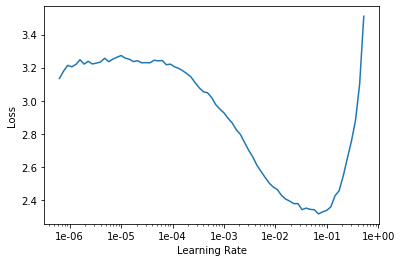

In [0]:
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [0]:
gc.collect()

7330

In [0]:
learn.fit_one_cycle(4, 4e-2, wd=2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.271290,4.795483,0.777273,0.222727,04:41
1,2.407334,2.431648,0.618182,0.381818,04:09
2,1.901382,1.749847,0.536364,0.463636,04:03
3,1.463382,1.226640,0.468182,0.531818,04:06


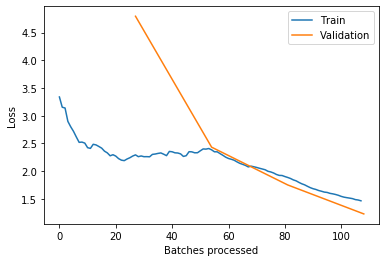

In [0]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
gc.collect()

2820

In [0]:
#Save .pth File  
learn.save('wfs-effnet-v4-phase1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


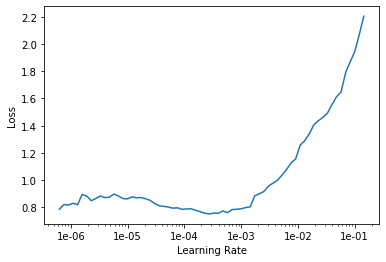

In [0]:
learn.unfreeze()
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, (4e-5,4e-4,4e-4), wd=2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.923791,1.145542,0.413636,0.586364,04:05
1,0.875554,1.221798,0.440909,0.559091,04:03
2,0.751939,1.182260,0.377273,0.622727,04:04
3,0.531241,1.042299,0.354545,0.645455,03:59


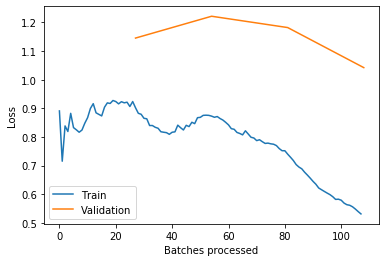

In [0]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
gc.collect()

9784

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


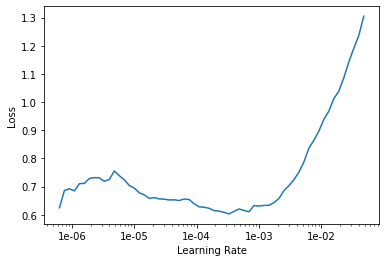

In [0]:
#Generate New Augmented Images
size=288
src = ImageList.from_folder(path/'train').split_by_rand_pct().label_from_folder().transform(tfms, size=size)   
data2 = (src).databunch(bs=bs).normalize(imagenet_stats)
#Attach to the Learner 
learn.data = data2 
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [0]:
gc.collect()

6441

In [0]:
learn.fit_one_cycle(4, (4e-5,4e-4,4e-4), wd=2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.652764,0.705973,0.250000,0.750000,04:18
1,0.657030,0.628261,0.236364,0.763636,04:17
2,0.536473,0.590199,0.218182,0.781818,04:19
3,0.380972,0.617682,0.218182,0.781818,04:13


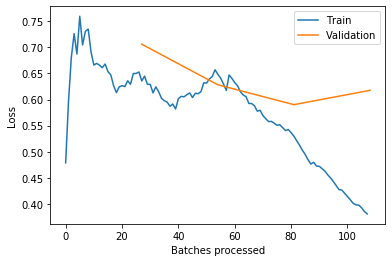

In [0]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
gc.collect()

2863

In [0]:
#Save .pth File  
learn.save('wfs-effnet-v4-phase2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


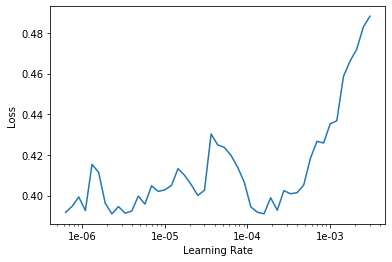

In [0]:
#Generate New Augmented Images
size=304
src = ImageList.from_folder(path/'train').split_by_rand_pct().label_from_folder().transform(tfms, size=size)   
data3 = (src).databunch(bs=bs).normalize(imagenet_stats)
#Attach to the Learner 
learn.data = data3 
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [0]:
gc.collect()

5720

In [0]:
learn.fit_one_cycle(4, (4e-4,4e-4,4e-4), wd=2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.404314,0.401531,0.136364,0.863636,04:23
1,0.515329,0.697561,0.240909,0.759091,04:20
2,0.538660,0.575011,0.195455,0.804545,04:21
3,0.373118,0.440941,0.172727,0.827273,04:22


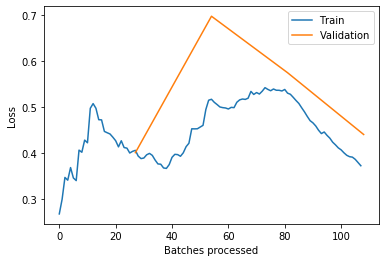

In [0]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
gc.collect()

2689

In [0]:
#Save .pth File  
learn.save('wfs-effnet-v4-phase3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


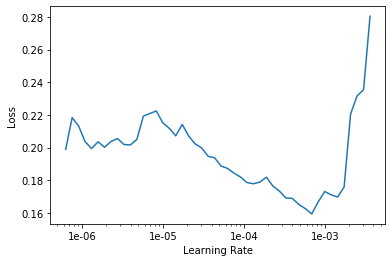

In [0]:
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [0]:
gc.collect()

5834

In [0]:
learn.fit_one_cycle(4, (4e-5,4e-5,4e-4), wd=2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.156827,0.401270,0.140909,0.859091,04:18
1,0.135386,0.409659,0.150000,0.850000,04:15
2,0.099172,0.418230,0.154545,0.845455,04:17
3,0.082814,0.414552,0.168182,0.831818,04:15


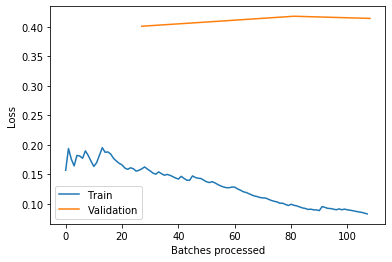

In [0]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
gc.collect()

2819

In [0]:
#Save .pth File  
learn.save('wfs-effnet-v4-phase4')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


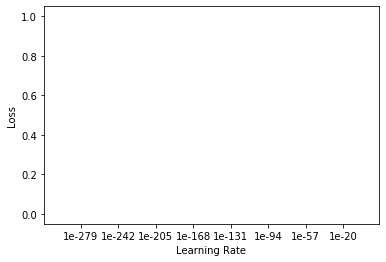

In [0]:
learn.freeze()
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [0]:
gc.collect()

2589

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


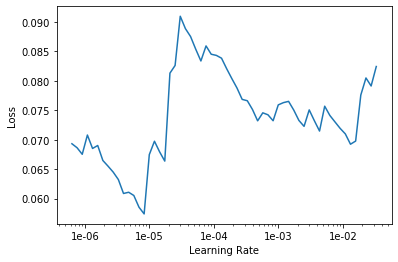

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, 6e-4, wd=2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.064420,0.410174,0.122727,0.877273,04:13
1,0.058326,0.433261,0.140909,0.859091,04:11
2,0.043927,0.457118,0.159091,0.840909,04:16
3,0.042174,0.446374,0.154545,0.845455,04:14


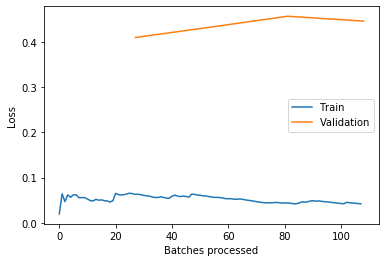

In [0]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
gc.collect()

9048

In [0]:
learn.load('wfs-effnet-v4-phase4')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


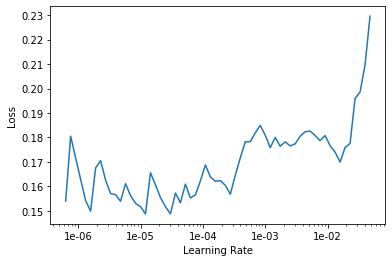

In [0]:
#Generate New Augmented Images
size=320
src = ImageList.from_folder(path/'train').split_by_rand_pct().label_from_folder().transform(tfms, size=size)   
data4 = (src).databunch(bs=bs).normalize(imagenet_stats)
#Attach to the Learner 
learn.data = data4 
learn.freeze()
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [0]:
gc.collect()

6513

In [0]:
learn.fit_one_cycle(2, 6e-6, wd=2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.171150,0.081765,0.022727,0.977273,04:18
1,0.193430,0.081053,0.022727,0.977273,04:18


In [0]:
gc.collect()

13

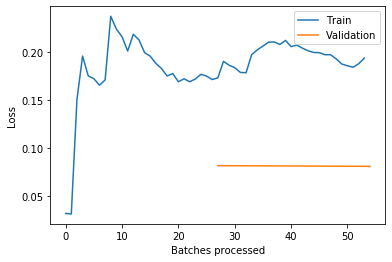

In [0]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
learn.save('wfs-effnet-v4-phase5')

In [0]:
learn.export(file="effnet-b1-c97.pkl")

In [0]:
gc.collect()

6944

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


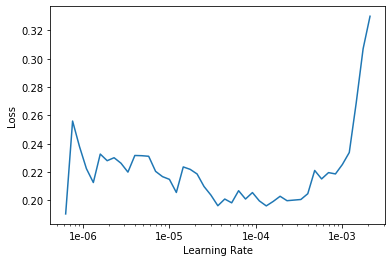

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
gc.collect()

5818

In [0]:
learn.fit_one_cycle(4, (4e-5,4e-5,4e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.219817,0.094194,0.022727,0.977273,04:25
1,0.167401,0.079650,0.022727,0.977273,04:27
2,0.117197,0.080619,0.018182,0.981818,04:26
3,0.078958,0.078760,0.018182,0.981818,04:26


In [0]:
learn.save('wfs-effnet-v4-phase6')

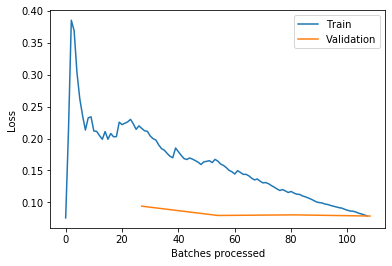

In [0]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
gc.collect()

2805

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


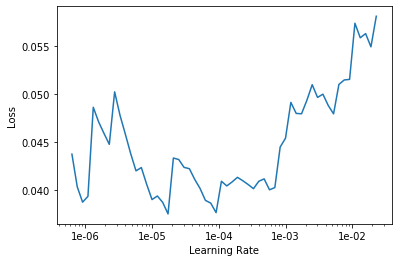

In [0]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
gc.collect()

6183

In [0]:
learn.fit_one_cycle(2, 4e-5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.045689,0.075329,0.013636,0.986364,04:14
1,0.044232,0.082112,0.018182,0.981818,04:18


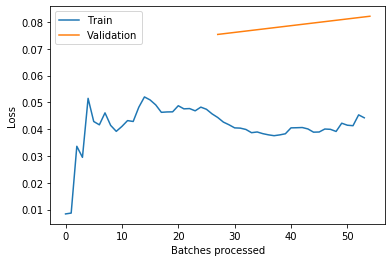

In [0]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
learn.export(file="effnet-b1-c98.pkl")

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.plot_top_losses(9, figsize=(20, 20))

Output hidden; open in https://colab.research.google.com to view.

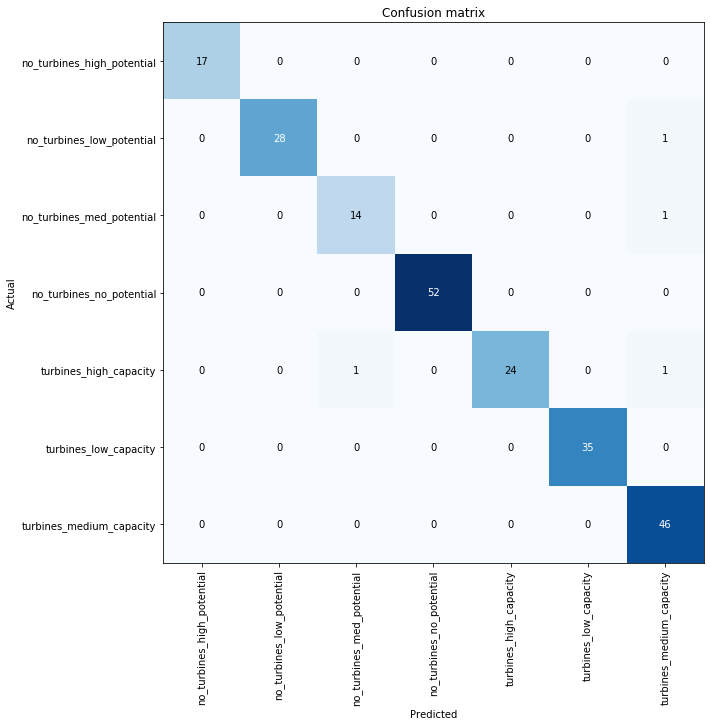

In [0]:
interp.plot_confusion_matrix(figsize=(10, 10))

In [0]:
gc.collect()

48509